# OC PROJET 7 - Developper une preuve de concept
<br></br>
<div id="toc"></div>

Ce projet à pour but d'améliorer les performances du projet de classification automatique des races de chiens<br> 
en se basant sur le dataset d'images de Stanford Dogs Dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/).

Divers module State-Of-The-Art vont être testé et comparé tel que Lion, CoCa, DaVit,<br> 
nous allons voir chaque module un par un et enfin faire des benchmarks comparatifs pour conclure.


### SOMMAIRE
- <a href="#C1">I. Setup</a>
    - <a href="#C11">1. Installation</a>
    - <a href="#C12">2. Fonctions Principales</a>
<br></br>   
    
- <a href="#C2">II. Tests</a>
     - 1. <a href="#C21">Lion</a>
     - 2. <a href="#C22">CoaT</a>
     - 3. <a href="#C23">DaVit</a>
<br></br> 
     
- <a href="#C3">III. Benchmark</a>
     - 1. <a href="#C31">Lion</a>
     - 2. <a href="#C32">CoCa</a>
     - 3. <a href="#C33">DaVit</a>
     

<br></br>      


# 1. Setup

## 1.1 Installation

In [ ]:
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

In [1]:
# general modules
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# pytorch modules
import torch
import torchvision
import torch.nn as nn
from torch import nn, optim
from torch.optim import Adam
from lion_pytorch import Lion
from torch.nn import Transformer
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader

# scikit-learn modules
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
#GPU check
print(torch.cuda.is_available())

True


In [3]:
# Vérifier si le GPU est disponible et l'attribuer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Chemin vers le dossier contenant les images
data_dir = "Images"

## 1.2 Fonctions Principales

### Entrainement du modèle

In [5]:
# Fonction pour l'entrainement et la validation
def train_and_validate(model, criterion, optimizer, epochs=25):
    history = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Initialize the progress bar
            pbar = tqdm(dataloader)

            # Iterate over data
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update the progress bar
                pbar.set_description(f'{phase} Loss: {running_loss:.4f} {phase} Acc: {running_corrects.double()/len(dataloader.dataset):.4f}')

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

            history.append({'epoch': epoch+1, 'phase': phase, 'loss': epoch_loss, 'acc': epoch_acc})

    return model, history

### Evaluation du modèle

In [6]:
def evaluate_model(model, val_loader, class_names, device):
    """
    Évalue le modèle de classification d'image sur le jeu de validation.

    Args:
    model : Le modèle entraîné.
    val_loader : DataLoader pour les données de validation.
    class_names : Noms des classes.
    device : Dispositif sur lequel exécuter le modèle (par exemple, 'cpu' ou 'cuda').

    Returns:
    Un rapport de classification pour le modèle sur le jeu de validation.
    """
    # Mettre le modèle en mode d'évaluation
    model.eval()

    all_labels = []
    all_preds = []

    # Itérer sur toutes les données de validation
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Calculer les prédictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Ajouter les labels et les prédictions à leurs listes respectives
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculer et retourner le rapport de classification
    return classification_report(all_labels, all_preds, target_names=class_names)

### Transformations, Data Augmentation

In [7]:
# Définir les transformations pour l'ensemble d'entraînement (avec data augmentation) et de test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(330),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Tests
<a href="#toc">Revenir en haut</a>
## 2.1 Lion
### 2.1.1 InceptionV3 SGD

In [88]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=train_transforms)

In [89]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [90]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [94]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weights=True)

In [95]:
# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

In [96]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [97]:
# Charger le GPU pour le modèle
model = model.to(device)

In [98]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [99]:
# Définition de l'optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [100]:
# Train and validate
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 91477.5756 train Acc: 0.1320: 100%|██████████| 226/226 [01:24<00:00,  2.67it/s]


train Loss: 6.3504 train Acc: 0.1320


val Loss: 12717.9142 val Acc: 0.4312: 100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


val Loss: 4.1198 val Acc: 0.4312
Epoch 2/20


train Loss: 78309.7925 train Acc: 0.4371: 100%|██████████| 226/226 [01:25<00:00,  2.63it/s]


train Loss: 5.4363 train Acc: 0.4371


val Loss: 10703.9666 val Acc: 0.5750: 100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


val Loss: 3.4674 val Acc: 0.5750
Epoch 3/20


train Loss: 67103.2770 train Acc: 0.5563: 100%|██████████| 226/226 [01:26<00:00,  2.62it/s]


train Loss: 4.6583 train Acc: 0.5563


val Loss: 8978.2559 val Acc: 0.6544: 100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


val Loss: 2.9084 val Acc: 0.6544
Epoch 4/20


train Loss: 57756.4274 train Acc: 0.6218: 100%|██████████| 226/226 [01:28<00:00,  2.54it/s]


train Loss: 4.0095 train Acc: 0.6218


val Loss: 7663.9735 val Acc: 0.6761: 100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


val Loss: 2.4827 val Acc: 0.6761
Epoch 5/20


train Loss: 50721.2882 train Acc: 0.6539: 100%|██████████| 226/226 [01:30<00:00,  2.50it/s]


train Loss: 3.5211 train Acc: 0.6539


val Loss: 6630.8724 val Acc: 0.7136: 100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


val Loss: 2.1480 val Acc: 0.7136
Epoch 6/20


train Loss: 45260.4885 train Acc: 0.6760: 100%|██████████| 226/226 [01:31<00:00,  2.47it/s]


train Loss: 3.1420 train Acc: 0.6760


val Loss: 5792.4416 val Acc: 0.7344: 100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


val Loss: 1.8764 val Acc: 0.7344
Epoch 7/20


train Loss: 41134.7713 train Acc: 0.6859: 100%|██████████| 226/226 [01:35<00:00,  2.38it/s]


train Loss: 2.8556 train Acc: 0.6859


val Loss: 5185.0017 val Acc: 0.7483: 100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


val Loss: 1.6796 val Acc: 0.7483
Epoch 8/20


train Loss: 38061.9323 train Acc: 0.6977: 100%|██████████| 226/226 [01:35<00:00,  2.38it/s]


train Loss: 2.6423 train Acc: 0.6977


val Loss: 4663.0304 val Acc: 0.7464: 100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


val Loss: 1.5105 val Acc: 0.7464
Epoch 9/20


train Loss: 35293.1241 train Acc: 0.7078: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 2.4501 train Acc: 0.7078


val Loss: 4384.8585 val Acc: 0.7554: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


val Loss: 1.4204 val Acc: 0.7554
Epoch 10/20


train Loss: 33308.9041 train Acc: 0.7129: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 2.3123 train Acc: 0.7129


val Loss: 4403.5158 val Acc: 0.7340: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


val Loss: 1.4265 val Acc: 0.7340
Epoch 11/20


train Loss: 31751.6944 train Acc: 0.7166: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 2.2042 train Acc: 0.7166


val Loss: 3952.8103 val Acc: 0.7671: 100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


val Loss: 1.2805 val Acc: 0.7671
Epoch 12/20


train Loss: 30526.8150 train Acc: 0.7191: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 2.1192 train Acc: 0.7191


val Loss: 3895.5093 val Acc: 0.7535: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 1.2619 val Acc: 0.7535
Epoch 13/20


train Loss: 29192.2269 train Acc: 0.7235: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 2.0265 train Acc: 0.7235


val Loss: 3644.0809 val Acc: 0.7723: 100%|██████████| 49/49 [00:20<00:00,  2.38it/s]


val Loss: 1.1805 val Acc: 0.7723
Epoch 14/20


train Loss: 28582.5954 train Acc: 0.7211: 100%|██████████| 226/226 [01:38<00:00,  2.30it/s]


train Loss: 1.9842 train Acc: 0.7211


val Loss: 3371.1500 val Acc: 0.7807: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


val Loss: 1.0920 val Acc: 0.7807
Epoch 15/20


train Loss: 27653.0957 train Acc: 0.7313: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 1.9197 train Acc: 0.7313


val Loss: 3419.8351 val Acc: 0.7690: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


val Loss: 1.1078 val Acc: 0.7690
Epoch 16/20


train Loss: 26871.9739 train Acc: 0.7356: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 1.8655 train Acc: 0.7356


val Loss: 3336.6170 val Acc: 0.7690: 100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


val Loss: 1.0809 val Acc: 0.7690
Epoch 17/20


train Loss: 26461.9087 train Acc: 0.7286: 100%|██████████| 226/226 [01:39<00:00,  2.28it/s]


train Loss: 1.8370 train Acc: 0.7286


val Loss: 3227.9161 val Acc: 0.7742: 100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


val Loss: 1.0456 val Acc: 0.7742
Epoch 18/20


train Loss: 25674.4455 train Acc: 0.7356: 100%|██████████| 226/226 [01:38<00:00,  2.29it/s]


train Loss: 1.7823 train Acc: 0.7356


val Loss: 3351.0333 val Acc: 0.7632: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


val Loss: 1.0855 val Acc: 0.7632
Epoch 19/20


train Loss: 25400.7368 train Acc: 0.7340: 100%|██████████| 226/226 [01:40<00:00,  2.25it/s]


train Loss: 1.7633 train Acc: 0.7340


val Loss: 3241.3255 val Acc: 0.7642: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


val Loss: 1.0500 val Acc: 0.7642
Epoch 20/20


train Loss: 25106.3547 train Acc: 0.7309: 100%|██████████| 226/226 [01:39<00:00,  2.28it/s]


train Loss: 1.7429 train Acc: 0.7309


val Loss: 3243.3617 val Acc: 0.7674: 100%|██████████| 49/49 [00:19<00:00,  2.45it/s]

val Loss: 1.0507 val Acc: 0.7674


In [101]:
# Get class names
class_names = dataset.classes

In [102]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.84      1.00      0.91        32
           African_hunting_dog       0.77      1.00      0.87        20
                      Airedale       0.76      0.90      0.82        31
American_Staffordshire_terrier       0.55      0.60      0.57        20
                   Appenzeller       0.75      0.60      0.67        25
            Australian_terrier       0.79      0.82      0.81        28
            Bedlington_terrier       0.88      0.93      0.90        30
          Bernese_mountain_dog       0.91      0.94      0.92        32
              Blenheim_spaniel       0.85      0.85      0.85        27
                 Border_collie       0.69      0.75      0.72        24
                Border_terrier       1.00      0.97      0.99        34
                   Boston_bull       0.81      0.88      0.84        24
          Bouvier_des_Flandres       0.70      0.76      0.73  

In [103]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.80      0.88      0.83        40
           African_hunting_dog       0.72      1.00      0.84        21
                      Airedale       0.77      0.67      0.71        30
American_Staffordshire_terrier       0.59      0.54      0.57        24
                   Appenzeller       0.93      0.45      0.60        29
            Australian_terrier       0.68      0.81      0.74        26
            Bedlington_terrier       0.67      0.81      0.73        27
          Bernese_mountain_dog       0.71      0.90      0.79        30
              Blenheim_spaniel       0.78      0.84      0.81        25
                 Border_collie       0.67      0.74      0.70        19
                Border_terrier       0.81      0.85      0.83        26
                   Boston_bull       0.89      0.89      0.89        28
          Bouvier_des_Flandres       0.68      0.72      0.70  

### 2.1.2 InceptionV3 Lion
<a href="#toc">Revenir en haut</a>

In [ ]:
pip install lion-pytorch

In [105]:
from lion_pytorch import Lion

In [106]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=train_transforms)

In [107]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [108]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weigths=True)

In [110]:
# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

In [111]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [112]:
# Charger le GPU pour le modèle
model = model.to(device)

In [113]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [114]:
# Définition de l'optimizer
optimizer = Lion(model.parameters(), lr=0.001, weight_decay=0.01)

In [115]:
# Train and validate
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 39075.7667 train Acc: 0.6011: 100%|██████████| 226/226 [01:35<00:00,  2.37it/s]


train Loss: 2.7127 train Acc: 0.6011


val Loss: 4467.1320 val Acc: 0.7146: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


val Loss: 1.4471 val Acc: 0.7146
Epoch 2/20


train Loss: 43049.7900 train Acc: 0.6718: 100%|██████████| 226/226 [01:34<00:00,  2.38it/s]


train Loss: 2.9885 train Acc: 0.6718


val Loss: 5374.2457 val Acc: 0.7140: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 1.7409 val Acc: 0.7140
Epoch 3/20


train Loss: 49682.9139 train Acc: 0.6639: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 3.4490 train Acc: 0.6639


val Loss: 6209.1499 val Acc: 0.7185: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


val Loss: 2.0114 val Acc: 0.7185
Epoch 4/20


train Loss: 55486.8610 train Acc: 0.6557: 100%|██████████| 226/226 [01:34<00:00,  2.38it/s]


train Loss: 3.8519 train Acc: 0.6557


val Loss: 6730.0811 val Acc: 0.7204: 100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


val Loss: 2.1801 val Acc: 0.7204
Epoch 5/20


train Loss: 58526.3153 train Acc: 0.6632: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 4.0629 train Acc: 0.6632


val Loss: 7299.6559 val Acc: 0.7224: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


val Loss: 2.3646 val Acc: 0.7224
Epoch 6/20


train Loss: 60066.1875 train Acc: 0.6708: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 4.1698 train Acc: 0.6708


val Loss: 7534.3733 val Acc: 0.7172: 100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


val Loss: 2.4407 val Acc: 0.7172
Epoch 7/20


train Loss: 62753.5659 train Acc: 0.6705: 100%|██████████| 226/226 [01:33<00:00,  2.42it/s]


train Loss: 4.3564 train Acc: 0.6705


val Loss: 8409.8172 val Acc: 0.7208: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


val Loss: 2.7243 val Acc: 0.7208
Epoch 8/20


train Loss: 64509.4471 train Acc: 0.6704: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.4783 train Acc: 0.6704


val Loss: 7599.6772 val Acc: 0.7447: 100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


val Loss: 2.4618 val Acc: 0.7447
Epoch 9/20


train Loss: 68260.1858 train Acc: 0.6728: 100%|██████████| 226/226 [01:33<00:00,  2.41it/s]


train Loss: 4.7386 train Acc: 0.6728


val Loss: 8138.9992 val Acc: 0.7467: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 2.6365 val Acc: 0.7467
Epoch 10/20


train Loss: 68043.9062 train Acc: 0.6802: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.7236 train Acc: 0.6802


val Loss: 9520.8978 val Acc: 0.7185: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 3.0842 val Acc: 0.7185
Epoch 11/20


train Loss: 70573.9080 train Acc: 0.6807: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.8993 train Acc: 0.6807


val Loss: 8559.1816 val Acc: 0.7311: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 2.7727 val Acc: 0.7311
Epoch 12/20


train Loss: 70976.6009 train Acc: 0.6825: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.9272 train Acc: 0.6825


val Loss: 9107.4040 val Acc: 0.7340: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 2.9502 val Acc: 0.7340
Epoch 13/20


train Loss: 74278.4938 train Acc: 0.6835: 100%|██████████| 226/226 [01:33<00:00,  2.41it/s]


train Loss: 5.1564 train Acc: 0.6835


val Loss: 9329.5360 val Acc: 0.7340: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


val Loss: 3.0222 val Acc: 0.7340
Epoch 14/20


train Loss: 74888.0640 train Acc: 0.6817: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.1988 train Acc: 0.6817


val Loss: 9686.3769 val Acc: 0.7331: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 3.1378 val Acc: 0.7331
Epoch 15/20


train Loss: 75709.2416 train Acc: 0.6834: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.2558 train Acc: 0.6834


val Loss: 10361.6238 val Acc: 0.7256: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


val Loss: 3.3565 val Acc: 0.7256
Epoch 16/20


train Loss: 76215.6702 train Acc: 0.6884: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.2909 train Acc: 0.6884


val Loss: 10453.1406 val Acc: 0.7357: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 3.3862 val Acc: 0.7357
Epoch 17/20


train Loss: 76811.1957 train Acc: 0.6919: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.3323 train Acc: 0.6919


val Loss: 10830.3946 val Acc: 0.7188: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


val Loss: 3.5084 val Acc: 0.7188
Epoch 18/20


train Loss: 78086.9752 train Acc: 0.6935: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.4208 train Acc: 0.6935


val Loss: 11338.5849 val Acc: 0.7263: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 3.6730 val Acc: 0.7263
Epoch 19/20


train Loss: 78362.4733 train Acc: 0.6901: 100%|██████████| 226/226 [01:35<00:00,  2.37it/s]


train Loss: 5.4399 train Acc: 0.6901


val Loss: 10776.4820 val Acc: 0.7289: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


val Loss: 3.4909 val Acc: 0.7289
Epoch 20/20


train Loss: 77592.4241 train Acc: 0.6938: 100%|██████████| 226/226 [01:37<00:00,  2.33it/s]


train Loss: 5.3865 train Acc: 0.6938


val Loss: 9401.0592 val Acc: 0.7480: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]

val Loss: 3.0454 val Acc: 0.7480


In [116]:
# Get class names
class_names = dataset.classes

In [117]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.81      0.76      0.79        29
           African_hunting_dog       0.92      0.92      0.92        24
                      Airedale       0.67      0.82      0.74        38
American_Staffordshire_terrier       0.73      0.65      0.69        17
                   Appenzeller       0.67      0.48      0.56        29
            Australian_terrier       0.62      0.71      0.67        28
            Bedlington_terrier       0.94      0.76      0.84        21
          Bernese_mountain_dog       0.74      0.86      0.79        29
              Blenheim_spaniel       0.96      0.77      0.86        35
                 Border_collie       0.57      0.35      0.43        23
                Border_terrier       0.81      0.86      0.83        29
                   Boston_bull       0.90      0.62      0.73        29
          Bouvier_des_Flandres       0.68      0.65      0.67  

In [118]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.85      0.88      0.86        40
           African_hunting_dog       0.80      0.80      0.80        25
                      Airedale       0.70      0.81      0.75        26
American_Staffordshire_terrier       0.59      0.62      0.61        16
                   Appenzeller       0.88      0.54      0.67        26
            Australian_terrier       0.71      0.85      0.77        26
            Bedlington_terrier       0.88      0.75      0.81        28
          Bernese_mountain_dog       0.82      0.80      0.81        35
              Blenheim_spaniel       0.92      0.89      0.91        27
                 Border_collie       0.73      0.33      0.46        24
                Border_terrier       0.64      0.88      0.74        24
                   Boston_bull       0.96      0.74      0.84        31
          Bouvier_des_Flandres       0.93      0.57      0.70  

### 2.1.3 InceptionV3 Adam
<a href="#toc">Revenir en haut</a>

In [56]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=train_transforms)

In [57]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [59]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [60]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weights=True)

In [61]:
# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

In [62]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [63]:
# Charger le GPU pour le modèle
model = model.to(device)

In [64]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [67]:
# Définition de l'optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [78]:
# Train and validate
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 26332.0547 train Acc: 0.7216: 100%|██████████| 226/226 [01:24<00:00,  2.69it/s]


train Loss: 1.8280 train Acc: 0.7216


val Loss: 3473.3072 val Acc: 0.7477: 100%|██████████| 49/49 [00:17<00:00,  2.76it/s]


val Loss: 1.1251 val Acc: 0.7477
Epoch 2/20


train Loss: 25923.2202 train Acc: 0.7215: 100%|██████████| 226/226 [01:25<00:00,  2.64it/s]


train Loss: 1.7996 train Acc: 0.7215


val Loss: 3532.7850 val Acc: 0.7399: 100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


val Loss: 1.1444 val Acc: 0.7399
Epoch 3/20


train Loss: 26792.4203 train Acc: 0.7079: 100%|██████████| 226/226 [01:28<00:00,  2.55it/s]


train Loss: 1.8599 train Acc: 0.7079


val Loss: 3377.5966 val Acc: 0.7509: 100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


val Loss: 1.0941 val Acc: 0.7509
Epoch 4/20


train Loss: 26406.9624 train Acc: 0.7175: 100%|██████████| 226/226 [01:32<00:00,  2.43it/s]


train Loss: 1.8332 train Acc: 0.7175


val Loss: 3445.2864 val Acc: 0.7480: 100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


val Loss: 1.1161 val Acc: 0.7480
Epoch 5/20


train Loss: 26613.0307 train Acc: 0.7104: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 1.8475 train Acc: 0.7104


val Loss: 3494.2511 val Acc: 0.7454: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


val Loss: 1.1319 val Acc: 0.7454
Epoch 6/20


train Loss: 26506.8477 train Acc: 0.7131: 100%|██████████| 226/226 [01:36<00:00,  2.33it/s]


train Loss: 1.8401 train Acc: 0.7131


val Loss: 3630.8394 val Acc: 0.7302: 100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


val Loss: 1.1762 val Acc: 0.7302
Epoch 7/20


train Loss: 26616.7885 train Acc: 0.7154: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 1.8477 train Acc: 0.7154


val Loss: 3597.0978 val Acc: 0.7302: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 1.1652 val Acc: 0.7302
Epoch 8/20


train Loss: 26482.7343 train Acc: 0.7139: 100%|██████████| 226/226 [01:34<00:00,  2.38it/s]


train Loss: 1.8384 train Acc: 0.7139


val Loss: 3568.1434 val Acc: 0.7324: 100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


val Loss: 1.1559 val Acc: 0.7324
Epoch 9/20


train Loss: 26509.7370 train Acc: 0.7175: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 1.8403 train Acc: 0.7175


val Loss: 3488.8891 val Acc: 0.7357: 100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


val Loss: 1.1302 val Acc: 0.7357
Epoch 10/20


train Loss: 26335.1106 train Acc: 0.7198: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 1.8282 train Acc: 0.7198


val Loss: 3624.6583 val Acc: 0.7331: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


val Loss: 1.1742 val Acc: 0.7331
Epoch 11/20


train Loss: 26291.4132 train Acc: 0.7167: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 1.8252 train Acc: 0.7167


val Loss: 3457.3499 val Acc: 0.7357: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


val Loss: 1.1200 val Acc: 0.7357
Epoch 12/20


train Loss: 26380.2620 train Acc: 0.7159: 100%|██████████| 226/226 [01:36<00:00,  2.33it/s]


train Loss: 1.8313 train Acc: 0.7159


val Loss: 3646.5298 val Acc: 0.7311: 100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


val Loss: 1.1813 val Acc: 0.7311
Epoch 13/20


train Loss: 26359.5819 train Acc: 0.7165: 100%|██████████| 226/226 [01:37<00:00,  2.31it/s]


train Loss: 1.8299 train Acc: 0.7165


val Loss: 3599.8625 val Acc: 0.7266: 100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


val Loss: 1.1661 val Acc: 0.7266
Epoch 14/20


train Loss: 26397.4712 train Acc: 0.7200: 100%|██████████| 226/226 [01:36<00:00,  2.33it/s]


train Loss: 1.8325 train Acc: 0.7200


val Loss: 3537.1634 val Acc: 0.7434: 100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


val Loss: 1.1458 val Acc: 0.7434
Epoch 15/20


train Loss: 26616.7504 train Acc: 0.7146: 100%|██████████| 226/226 [01:39<00:00,  2.27it/s]


train Loss: 1.8477 train Acc: 0.7146


val Loss: 3367.6869 val Acc: 0.7467: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


val Loss: 1.0909 val Acc: 0.7467
Epoch 16/20


train Loss: 26407.4268 train Acc: 0.7171: 100%|██████████| 226/226 [01:35<00:00,  2.38it/s]


train Loss: 1.8332 train Acc: 0.7171


val Loss: 3372.2735 val Acc: 0.7502: 100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


val Loss: 1.0924 val Acc: 0.7502
Epoch 17/20


train Loss: 26783.8335 train Acc: 0.7112: 100%|██████████| 226/226 [01:33<00:00,  2.42it/s]


train Loss: 1.8593 train Acc: 0.7112


val Loss: 3477.2499 val Acc: 0.7408: 100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


val Loss: 1.1264 val Acc: 0.7408
Epoch 18/20


train Loss: 26317.9809 train Acc: 0.7188: 100%|██████████| 226/226 [01:39<00:00,  2.26it/s]


train Loss: 1.8270 train Acc: 0.7188


val Loss: 3400.9371 val Acc: 0.7470: 100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


val Loss: 1.1017 val Acc: 0.7470
Epoch 19/20


train Loss: 26337.1887 train Acc: 0.7202: 100%|██████████| 226/226 [01:42<00:00,  2.21it/s]


train Loss: 1.8283 train Acc: 0.7202


val Loss: 3650.2441 val Acc: 0.7328: 100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


val Loss: 1.1825 val Acc: 0.7328
Epoch 20/20


train Loss: 26561.4844 train Acc: 0.7146: 100%|██████████| 226/226 [01:39<00:00,  2.28it/s]


train Loss: 1.8439 train Acc: 0.7146


val Loss: 3533.4813 val Acc: 0.7412: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]

val Loss: 1.1446 val Acc: 0.7412


In [86]:
# Get class names
class_names = dataset.classes

In [82]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.87      0.96      0.92        28
           African_hunting_dog       0.89      0.96      0.93        26
                      Airedale       0.92      0.48      0.63        23
American_Staffordshire_terrier       0.74      0.57      0.64        30
                   Appenzeller       0.79      0.66      0.72        29
            Australian_terrier       0.78      0.81      0.79        26
            Bedlington_terrier       0.51      0.93      0.66        29
          Bernese_mountain_dog       0.87      0.74      0.80        35
              Blenheim_spaniel       0.83      0.83      0.83        29
                 Border_collie       0.55      0.85      0.67        20
                Border_terrier       0.91      0.95      0.93        22
                   Boston_bull       1.00      0.91      0.95        34
          Bouvier_des_Flandres       0.39      0.86      0.54  

In [87]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.86      0.77      0.81        39
           African_hunting_dog       0.86      0.97      0.91        32
                      Airedale       0.90      0.93      0.91        28
American_Staffordshire_terrier       0.73      0.57      0.64        28
                   Appenzeller       0.67      0.55      0.60        11
            Australian_terrier       0.71      0.75      0.73        32
            Bedlington_terrier       0.65      0.97      0.78        29
          Bernese_mountain_dog       0.98      0.91      0.94        45
              Blenheim_spaniel       0.96      0.76      0.85        33
                 Border_collie       0.57      0.76      0.65        17
                Border_terrier       0.91      0.95      0.93        21
                   Boston_bull       0.75      0.60      0.67        25
          Bouvier_des_Flandres       0.36      1.00      0.53  

## 2.1 CoaT

In [164]:
class CoaT(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(CoaT, self).__init__()
        
        # Define convolutional layer
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        
        # Define transformer block
        self.transformer = Transformer(d_model=512, nhead=8)
        
        # Define pooling layer
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Define fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Pass input through convolutional layer
        x = self.conv1(x)
        
        # Pass output through transformer block
        x = self.transformer(x)
        
        # Pass output through pooling layer
        x = self.pool(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Pass output through fully connected layer
        x = self.fc(x)
        
        return x

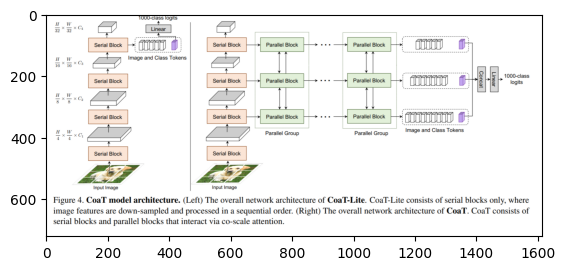

In [160]:
# Open the image file
img = Image.open('model.PNG')
plt.imshow(img)

In [165]:
def train_and_validate(model, criterion, optimizer, epochs=25):
    history = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Initialize the progress bar
            pbar = tqdm(dataloader)

            # Iterate over data
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update the progress bar
                pbar.set_description(f'{phase} Loss: {running_loss:.4f} {phase} Acc: {running_corrects.double()/len(dataloader.dataset):.4f}')

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

            history.append({'epoch': epoch+1, 'phase': phase, 'loss': epoch_loss, 'acc': epoch_acc})

    return model, history

In [11]:
pip install einops

     ---------------------------------------- 0.0/42.2 kB ? eta -:--:--
     --------------------------- ---------- 30.7/42.2 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 42.2/42.2 kB 507.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [166]:
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
import cv2
from coat import CoaT
import module
from torch.optim import lr_scheduler
import copy

In [167]:
# Define the transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [168]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=transform)

In [169]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [170]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [171]:
# Load Pre-trained model CoaT
model = CoaT(3, 224, 120)

In [172]:
# Freeze the parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

In [173]:
# Replace the last layer to fit our classification problem
num_ftrs = model.serial_mlp_head[1].in_features
model.serial_mlp_head[1] = nn.Linear(num_ftrs, 120)

In [174]:
# Load the GPU for the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.serial_mlp_head[1] = model.serial_mlp_head[1].to(device)
model = model.to(device)

In [175]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [183]:
# Définition de l'optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [184]:
# Train and validate the model
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 79687.2952 train Acc: 0.0208: 100%|██████████| 226/226 [00:58<00:00,  3.87it/s]


train Loss: 5.5319 train Acc: 0.0208


val Loss: 17187.3877 val Acc: 0.0146: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


val Loss: 5.5677 val Acc: 0.0146
Epoch 2/20


train Loss: 77560.1900 train Acc: 0.0236: 100%|██████████| 226/226 [00:59<00:00,  3.81it/s]


train Loss: 5.3843 train Acc: 0.0236


val Loss: 17429.6436 val Acc: 0.0168: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


val Loss: 5.6461 val Acc: 0.0168
Epoch 3/20


train Loss: 76568.2999 train Acc: 0.0292: 100%|██████████| 226/226 [00:58<00:00,  3.86it/s]


train Loss: 5.3154 train Acc: 0.0292


val Loss: 17722.1558 val Acc: 0.0198: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


val Loss: 5.7409 val Acc: 0.0198
Epoch 4/20


train Loss: 77001.8444 train Acc: 0.0285: 100%|██████████| 226/226 [00:59<00:00,  3.83it/s]


train Loss: 5.3455 train Acc: 0.0285


val Loss: 17201.7786 val Acc: 0.0230: 100%|██████████| 49/49 [00:12<00:00,  3.85it/s]


val Loss: 5.5723 val Acc: 0.0230
Epoch 5/20


train Loss: 75899.1949 train Acc: 0.0342: 100%|██████████| 226/226 [00:59<00:00,  3.82it/s]


train Loss: 5.2689 train Acc: 0.0342


val Loss: 17389.9468 val Acc: 0.0201: 100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


val Loss: 5.6333 val Acc: 0.0201
Epoch 6/20


train Loss: 76726.5632 train Acc: 0.0316: 100%|██████████| 226/226 [00:59<00:00,  3.82it/s]


train Loss: 5.3264 train Acc: 0.0316


val Loss: 17594.8022 val Acc: 0.0220: 100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


val Loss: 5.6996 val Acc: 0.0220
Epoch 7/20


train Loss: 75409.3667 train Acc: 0.0344: 100%|██████████| 226/226 [00:59<00:00,  3.77it/s]


train Loss: 5.2349 train Acc: 0.0344


val Loss: 17383.1246 val Acc: 0.0266: 100%|██████████| 49/49 [00:12<00:00,  3.80it/s]


val Loss: 5.6311 val Acc: 0.0266
Epoch 8/20


train Loss: 76068.5371 train Acc: 0.0340: 100%|██████████| 226/226 [00:59<00:00,  3.77it/s]


train Loss: 5.2807 train Acc: 0.0340


val Loss: 17028.2829 val Acc: 0.0217: 100%|██████████| 49/49 [00:12<00:00,  3.78it/s]


val Loss: 5.5161 val Acc: 0.0217
Epoch 9/20


train Loss: 75340.4232 train Acc: 0.0379: 100%|██████████| 226/226 [01:00<00:00,  3.76it/s]


train Loss: 5.2302 train Acc: 0.0379


val Loss: 17519.5531 val Acc: 0.0198: 100%|██████████| 49/49 [00:12<00:00,  3.83it/s]


val Loss: 5.6753 val Acc: 0.0198
Epoch 10/20


train Loss: 74944.0414 train Acc: 0.0383: 100%|██████████| 226/226 [00:59<00:00,  3.77it/s]


train Loss: 5.2026 train Acc: 0.0383


val Loss: 17260.0679 val Acc: 0.0314: 100%|██████████| 49/49 [00:13<00:00,  3.72it/s]


val Loss: 5.5912 val Acc: 0.0314
Epoch 11/20


train Loss: 75041.6559 train Acc: 0.0355: 100%|██████████| 226/226 [01:00<00:00,  3.76it/s]


train Loss: 5.2094 train Acc: 0.0355


val Loss: 17070.5013 val Acc: 0.0282: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


val Loss: 5.5298 val Acc: 0.0282
Epoch 12/20


train Loss: 74921.3075 train Acc: 0.0385: 100%|██████████| 226/226 [01:01<00:00,  3.69it/s]


train Loss: 5.2011 train Acc: 0.0385


val Loss: 17305.6481 val Acc: 0.0214: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


val Loss: 5.6060 val Acc: 0.0214
Epoch 13/20


train Loss: 75053.7956 train Acc: 0.0376: 100%|██████████| 226/226 [01:01<00:00,  3.69it/s]


train Loss: 5.2103 train Acc: 0.0376


val Loss: 17602.4481 val Acc: 0.0211: 100%|██████████| 49/49 [00:12<00:00,  3.79it/s]


val Loss: 5.7021 val Acc: 0.0211
Epoch 14/20


train Loss: 75323.1264 train Acc: 0.0405: 100%|██████████| 226/226 [01:00<00:00,  3.73it/s]


train Loss: 5.2290 train Acc: 0.0405


val Loss: 17453.0693 val Acc: 0.0217: 100%|██████████| 49/49 [00:13<00:00,  3.72it/s]


val Loss: 5.6537 val Acc: 0.0217
Epoch 15/20


train Loss: 74542.1337 train Acc: 0.0423: 100%|██████████| 226/226 [01:01<00:00,  3.70it/s]


train Loss: 5.1747 train Acc: 0.0423


val Loss: 16613.9619 val Acc: 0.0324: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


val Loss: 5.3819 val Acc: 0.0324
Epoch 16/20


train Loss: 74483.6617 train Acc: 0.0418: 100%|██████████| 226/226 [01:00<00:00,  3.73it/s]


train Loss: 5.1707 train Acc: 0.0418


val Loss: 17598.4774 val Acc: 0.0285: 100%|██████████| 49/49 [00:13<00:00,  3.76it/s]


val Loss: 5.7008 val Acc: 0.0285
Epoch 17/20


train Loss: 74628.8021 train Acc: 0.0412: 100%|██████████| 226/226 [01:00<00:00,  3.71it/s]


train Loss: 5.1808 train Acc: 0.0412


val Loss: 17322.4355 val Acc: 0.0233: 100%|██████████| 49/49 [00:12<00:00,  3.81it/s]


val Loss: 5.6114 val Acc: 0.0233
Epoch 18/20


train Loss: 74254.4851 train Acc: 0.0432: 100%|██████████| 226/226 [01:01<00:00,  3.67it/s]


train Loss: 5.1548 train Acc: 0.0432


val Loss: 17089.7363 val Acc: 0.0282: 100%|██████████| 49/49 [00:13<00:00,  3.70it/s]


val Loss: 5.5360 val Acc: 0.0282
Epoch 19/20


train Loss: 74606.3085 train Acc: 0.0421: 100%|██████████| 226/226 [01:01<00:00,  3.66it/s]


train Loss: 5.1792 train Acc: 0.0421


val Loss: 17708.1871 val Acc: 0.0230: 100%|██████████| 49/49 [00:13<00:00,  3.75it/s]


val Loss: 5.7364 val Acc: 0.0230
Epoch 20/20


train Loss: 74661.5531 train Acc: 0.0428: 100%|██████████| 226/226 [01:01<00:00,  3.69it/s]


train Loss: 5.1830 train Acc: 0.0428


val Loss: 17125.1429 val Acc: 0.0327: 100%|██████████| 49/49 [00:13<00:00,  3.69it/s]

val Loss: 5.5475 val Acc: 0.0327


In [185]:
# Get class names
class_names = dataset.classes

In [186]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.00      0.00      0.00        46
           African_hunting_dog       0.10      0.22      0.14        18
                      Airedale       0.12      0.03      0.05        31
American_Staffordshire_terrier       0.00      0.00      0.00        13
                   Appenzeller       0.00      0.00      0.00        18
            Australian_terrier       0.03      0.03      0.03        32
            Bedlington_terrier       0.17      0.04      0.07        24
          Bernese_mountain_dog       0.00      0.00      0.00        35
              Blenheim_spaniel       0.04      0.17      0.07        35
                 Border_collie       0.00      0.00      0.00        21
                Border_terrier       0.00      0.00      0.00        27
                   Boston_bull       0.02      0.13      0.04        23
          Bouvier_des_Flandres       0.00      0.00      0.00  

C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [187]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.00      0.00      0.00        41
           African_hunting_dog       0.06      0.09      0.07        22
                      Airedale       0.00      0.00      0.00        36
American_Staffordshire_terrier       0.00      0.00      0.00        31
                   Appenzeller       0.00      0.00      0.00        21
            Australian_terrier       0.00      0.00      0.00        32
            Bedlington_terrier       0.00      0.00      0.00        23
          Bernese_mountain_dog       0.00      0.00      0.00        30
              Blenheim_spaniel       0.04      0.24      0.06        21
                 Border_collie       0.00      0.00      0.00        22
                Border_terrier       0.00      0.00      0.00        24
                   Boston_bull       0.01      0.03      0.01        29
          Bouvier_des_Flandres       0.00      0.00      0.00  

C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2.3 Chimera Mix
<a href="#toc">Revenir en haut</a>

In [5]:
data_dir = "Images"

In [6]:
from chimera import ChimeraModel

In [7]:
def train_and_validate_chimeramix(model, criterion, optimizer, train_loader, val_loader, epochs=25):
    history = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Initialize the progress bar
            pbar = tqdm(dataloader)

            # Iterate over data
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        masks = create_masks(inputs.size(0), inputs.size(-1))
                        mixed_images, x_hat, y_hat, _ = model(inputs, inputs, masks)
                        outputs = model(mixed_images)
                        loss1 = criterion(outputs, labels)
                        loss = loss1
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update the progress bar
                pbar.set_description(f'{phase} Loss: {running_loss:.4f} {phase} Acc: {running_corrects.double()/len(dataloader.dataset):.4f}')

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

            history.append({'epoch': epoch+1, 'phase': phase, 'loss': epoch_loss, 'acc': epoch_acc})

    return model, history

In [8]:
# Charger les images et appliquer les transformations pour l'ensemble d'entraînement et de test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(330),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

In [10]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Créer les data loaders pour les ensembles d'entraînement, de validation et de test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [11]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weights=True)

# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [13]:
# Charger le GPU pour le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

# Définition de l'optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
def create_masks(batch_size, image_size):
    """
    Crée des masques de mélange aléatoires pour les images.

    Args:
    batch_size : Nombre d'images dans le batch.
    image_size : Taille de l'image (par exemple, 299 pour InceptionV3).

    Returns:
    Masques de mélange aléatoires de forme (batch_size, 1, image_size, image_size).
    """
    masks = torch.rand(batch_size, 1, image_size, image_size) < 0.5
    masks = masks.float()
    return masks

In [16]:
# Train and validate using ChimeraMix
model, history = train_and_validate_chimeramix(model, criterion, optimizer, train_loader, val_loader, epochs=20)

Epoch 1/20


  0%|          | 0/226 [00:00<?, ?it/s]


TypeError: forward() takes 2 positional arguments but 4 were given

In [ ]:
# Get class names
class_names = dataset.classes

In [ ]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

# 3. Benchmarks
<a href="#toc">Revenir en haut</a>

In [188]:
df1 = pd.read_csv('epochs_inception_torch_adam.csv')
df2 = pd.read_csv('epochs_inception_torch_lion.csv')
df3 = pd.read_csv('epochs_inception_torch_sgd.csv')

def convert_time_to_seconds(time_str):
    """Converts a time string in the format 'MM:SS' to seconds."""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Convert 'time' column to seconds
df1['time'] = df1['time'].apply(convert_time_to_seconds)
df2['time'] = df2['time'].apply(convert_time_to_seconds)
df3['time'] = df3['time'].apply(convert_time_to_seconds)

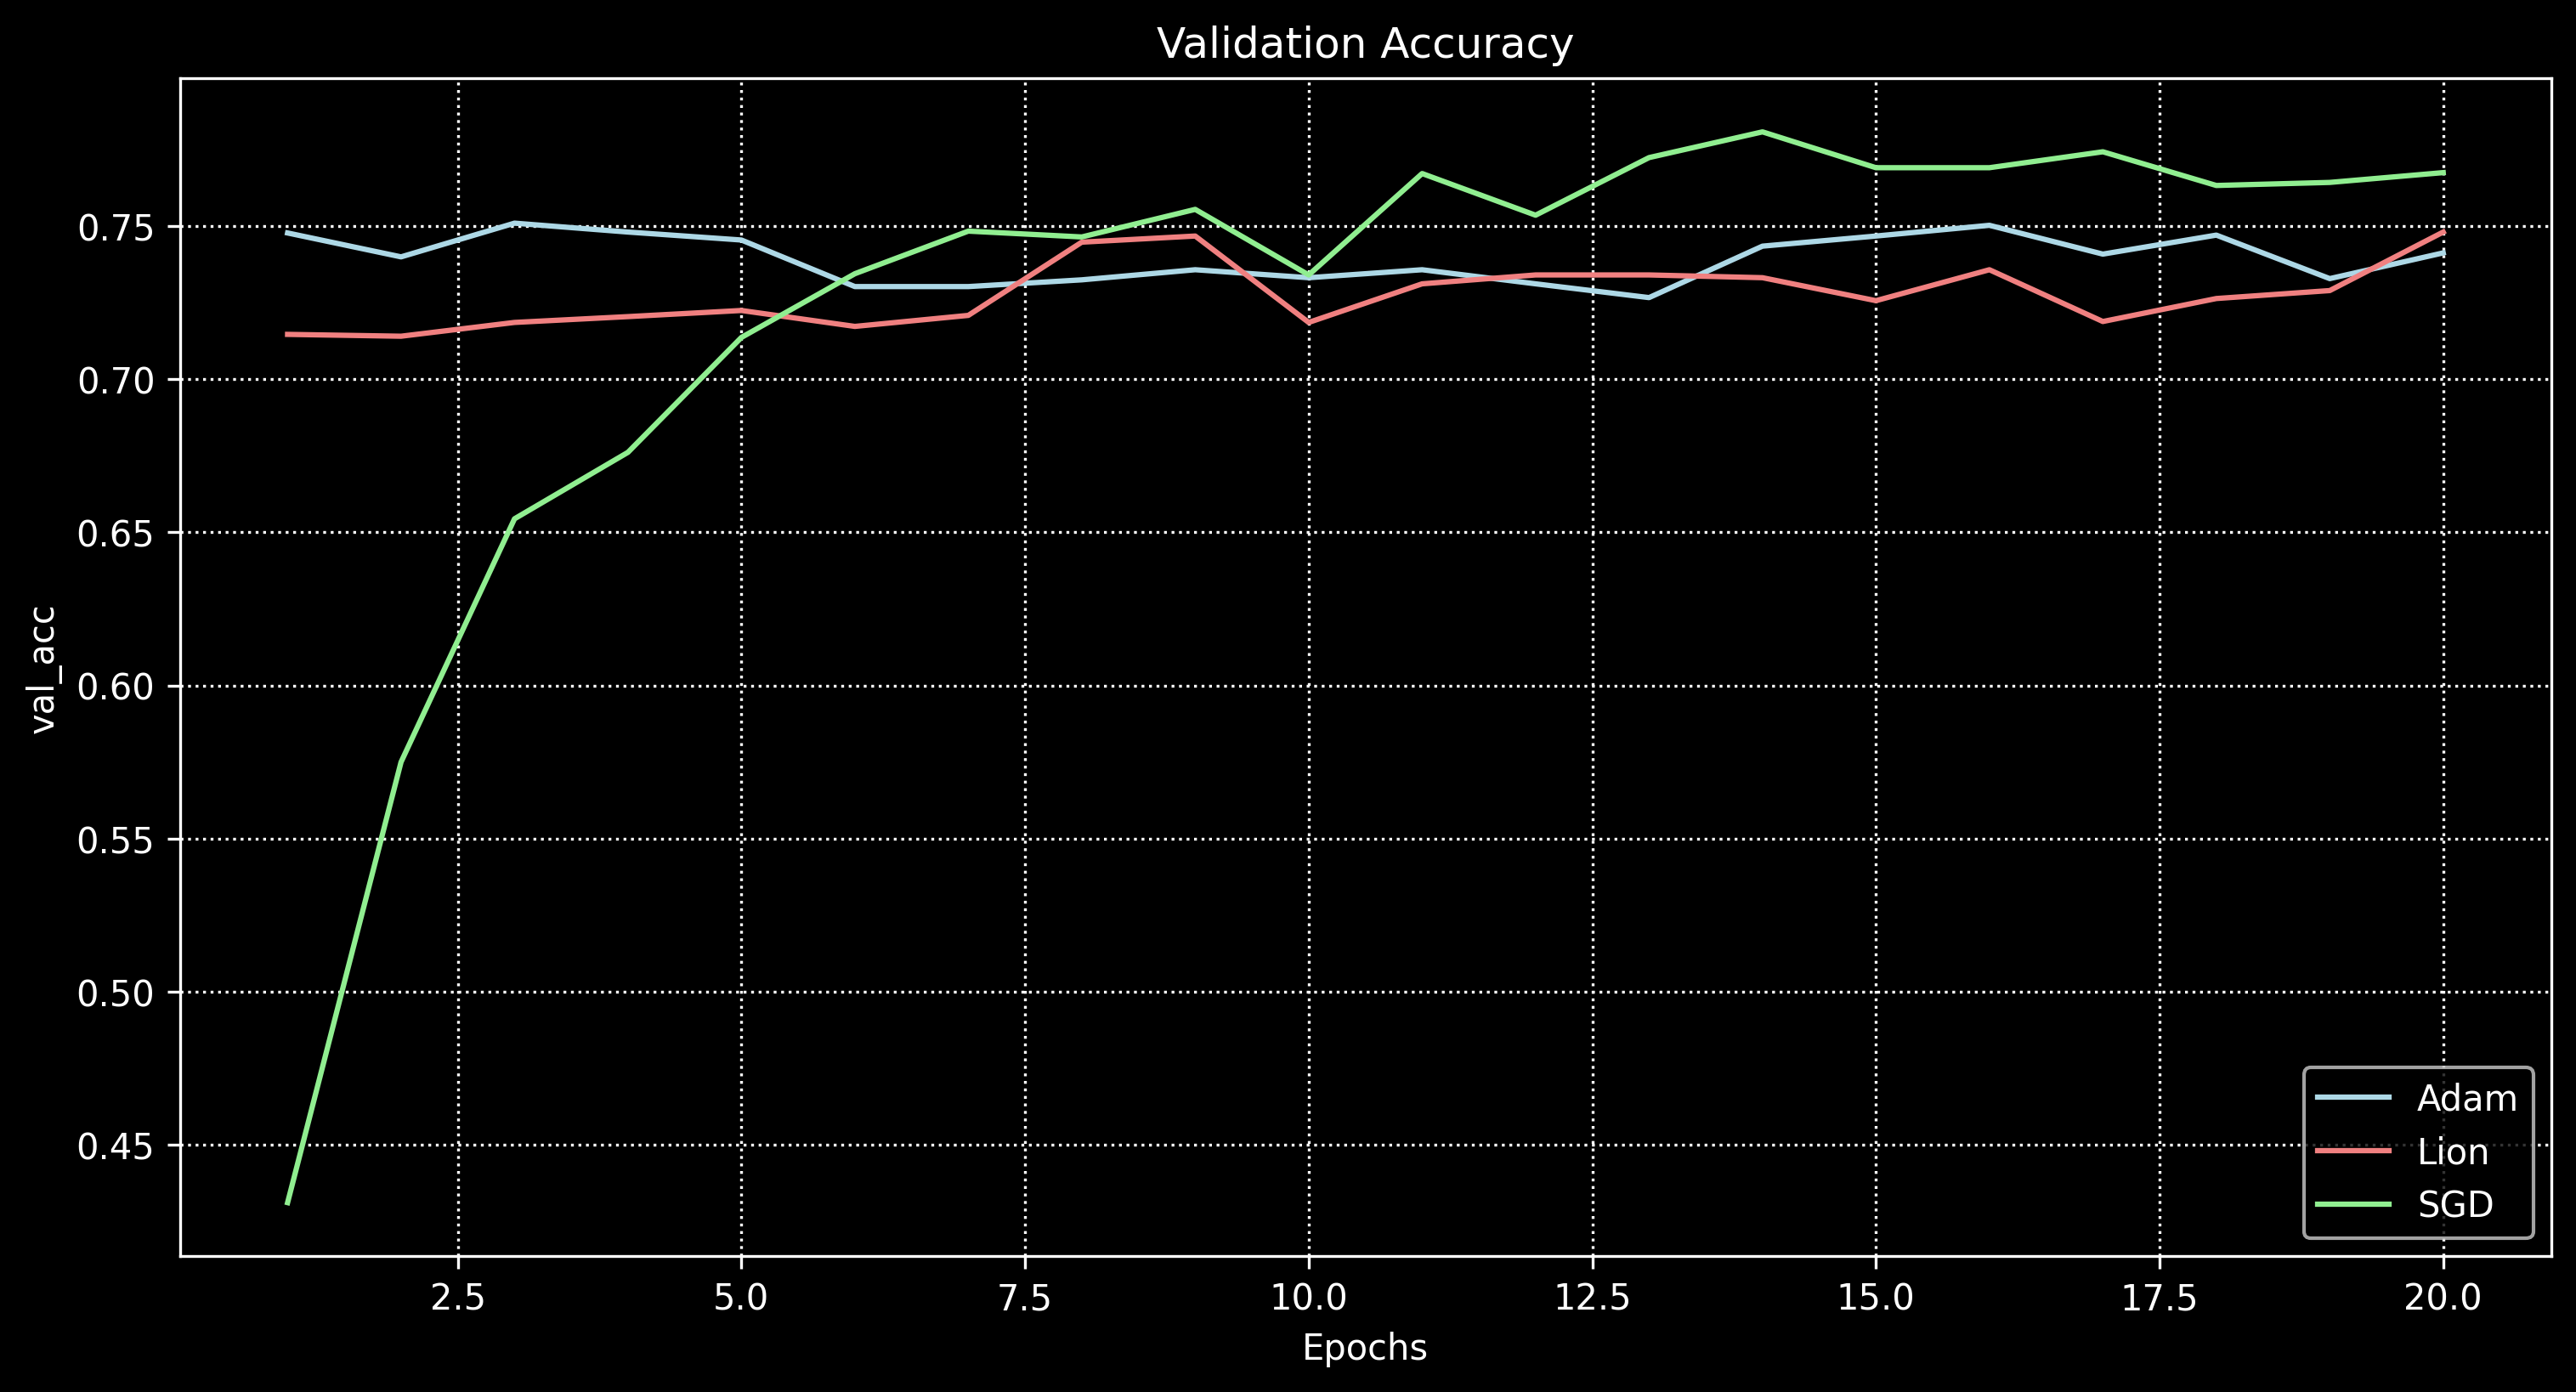

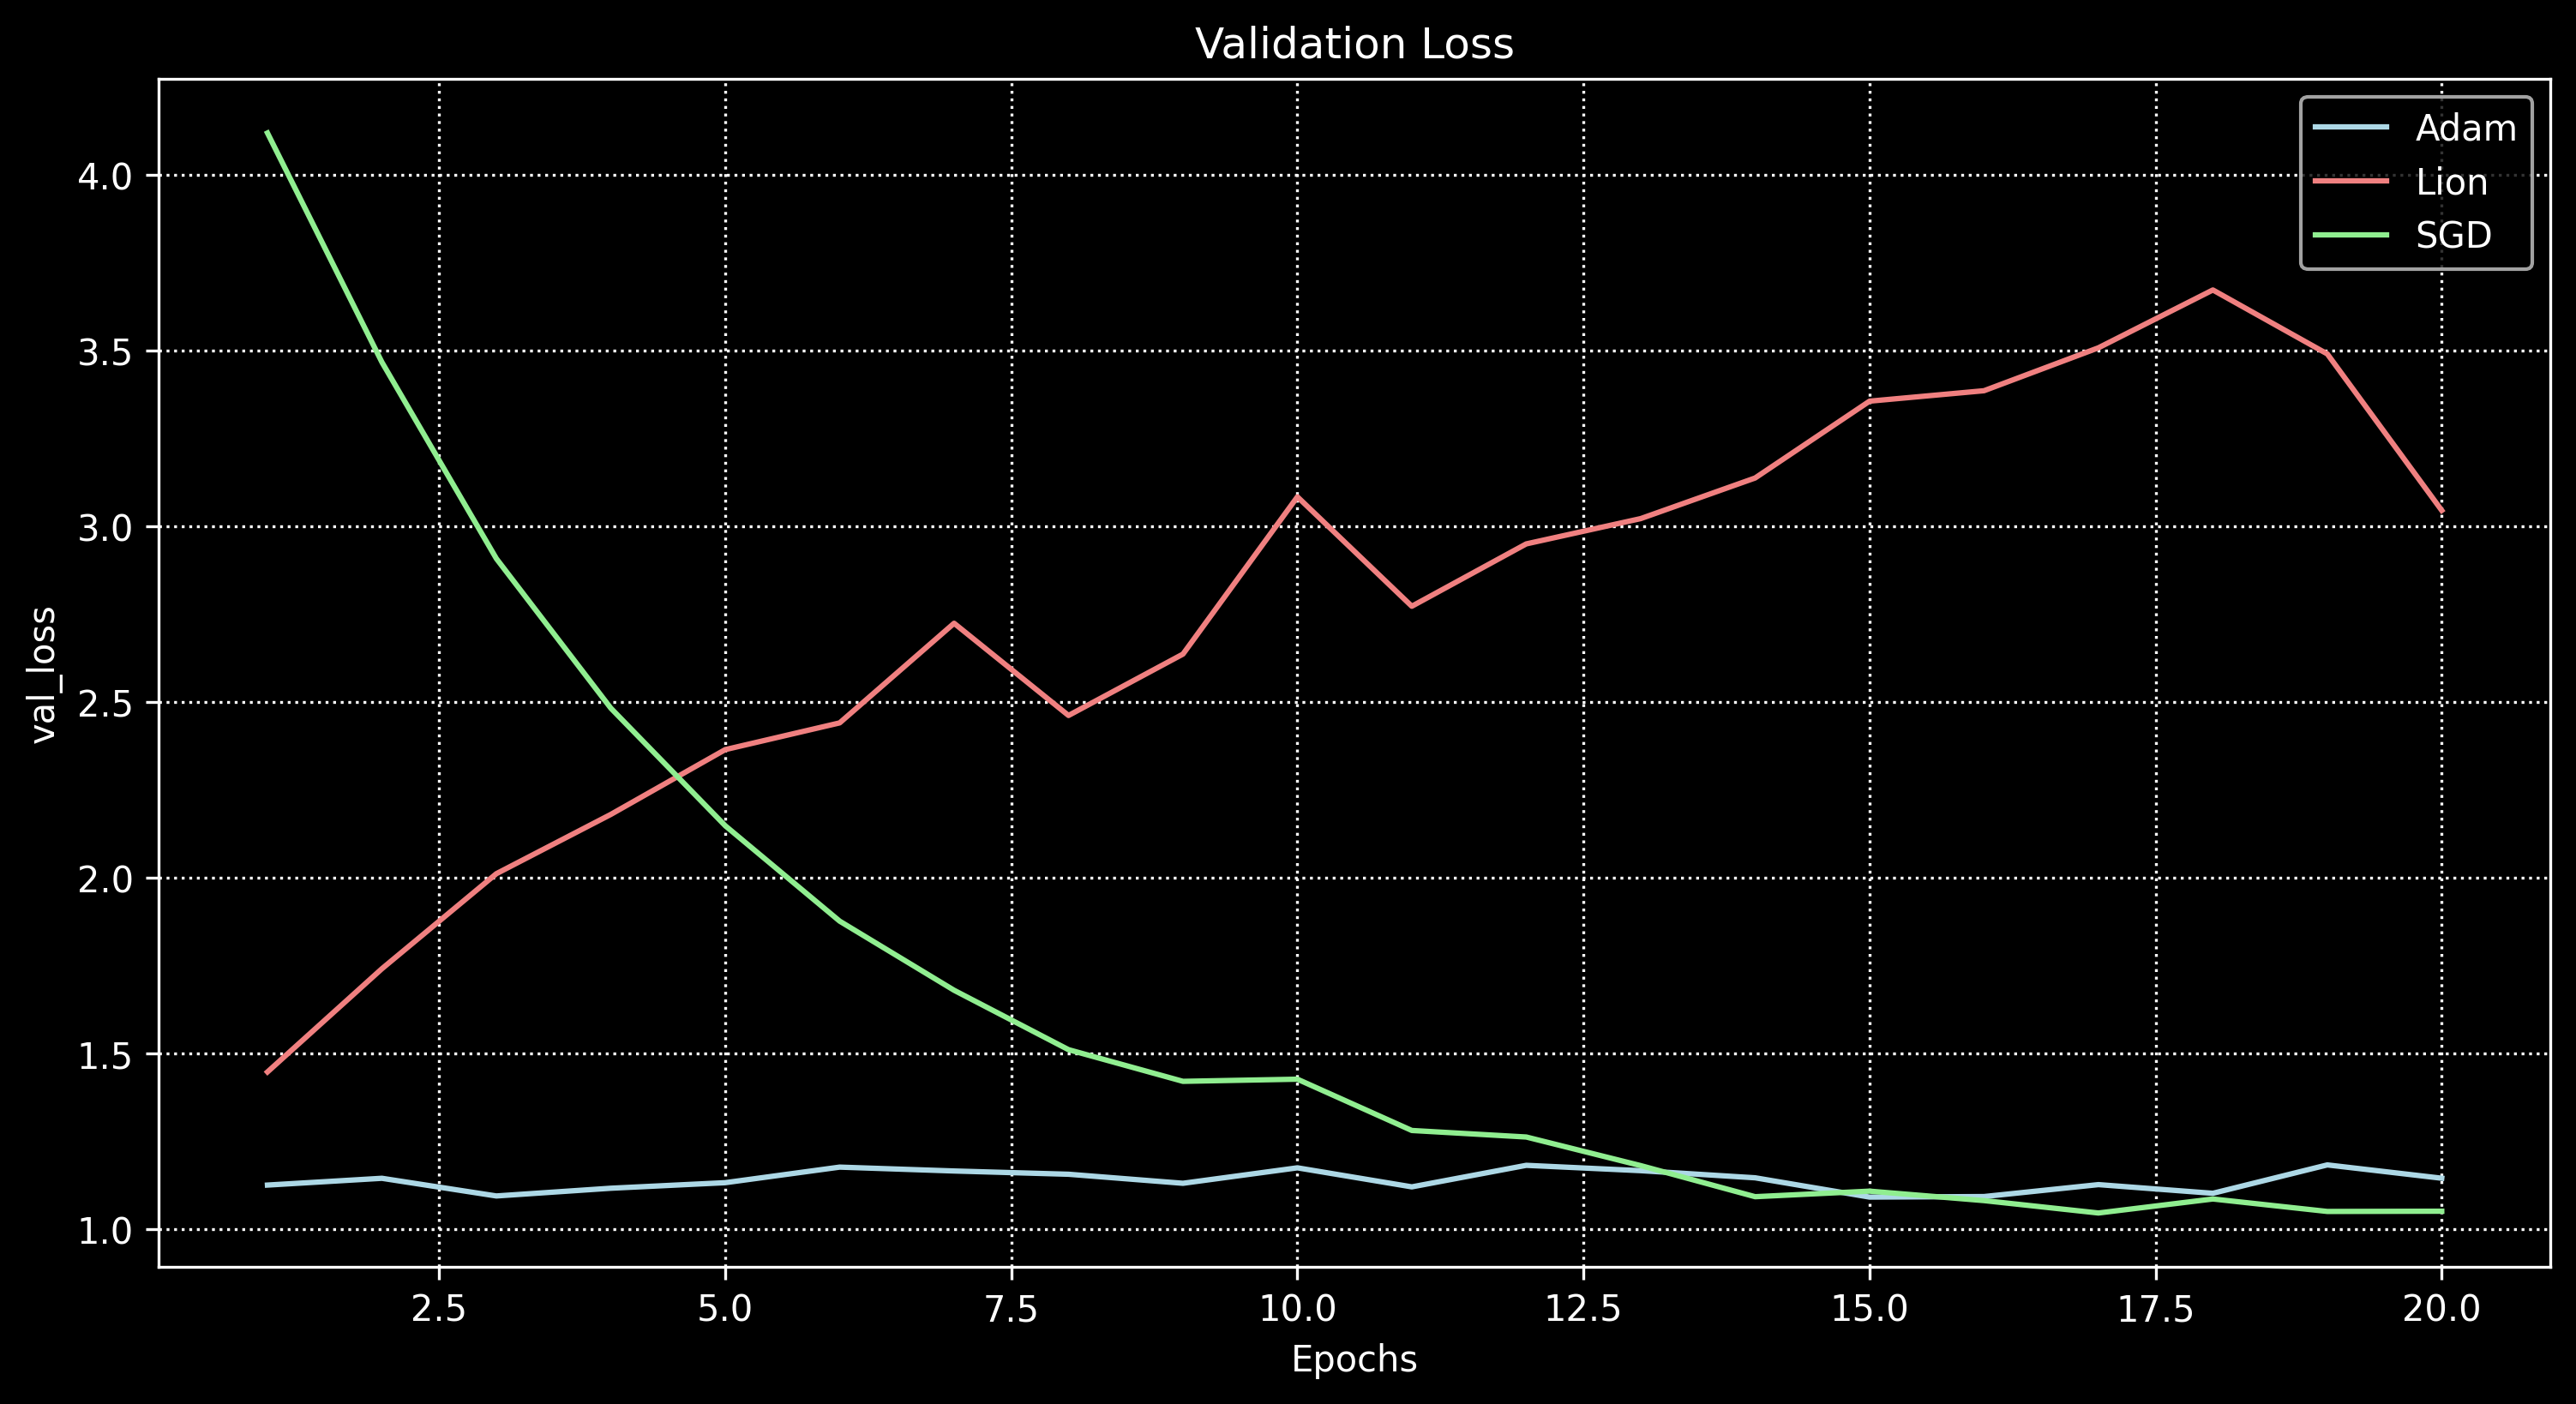

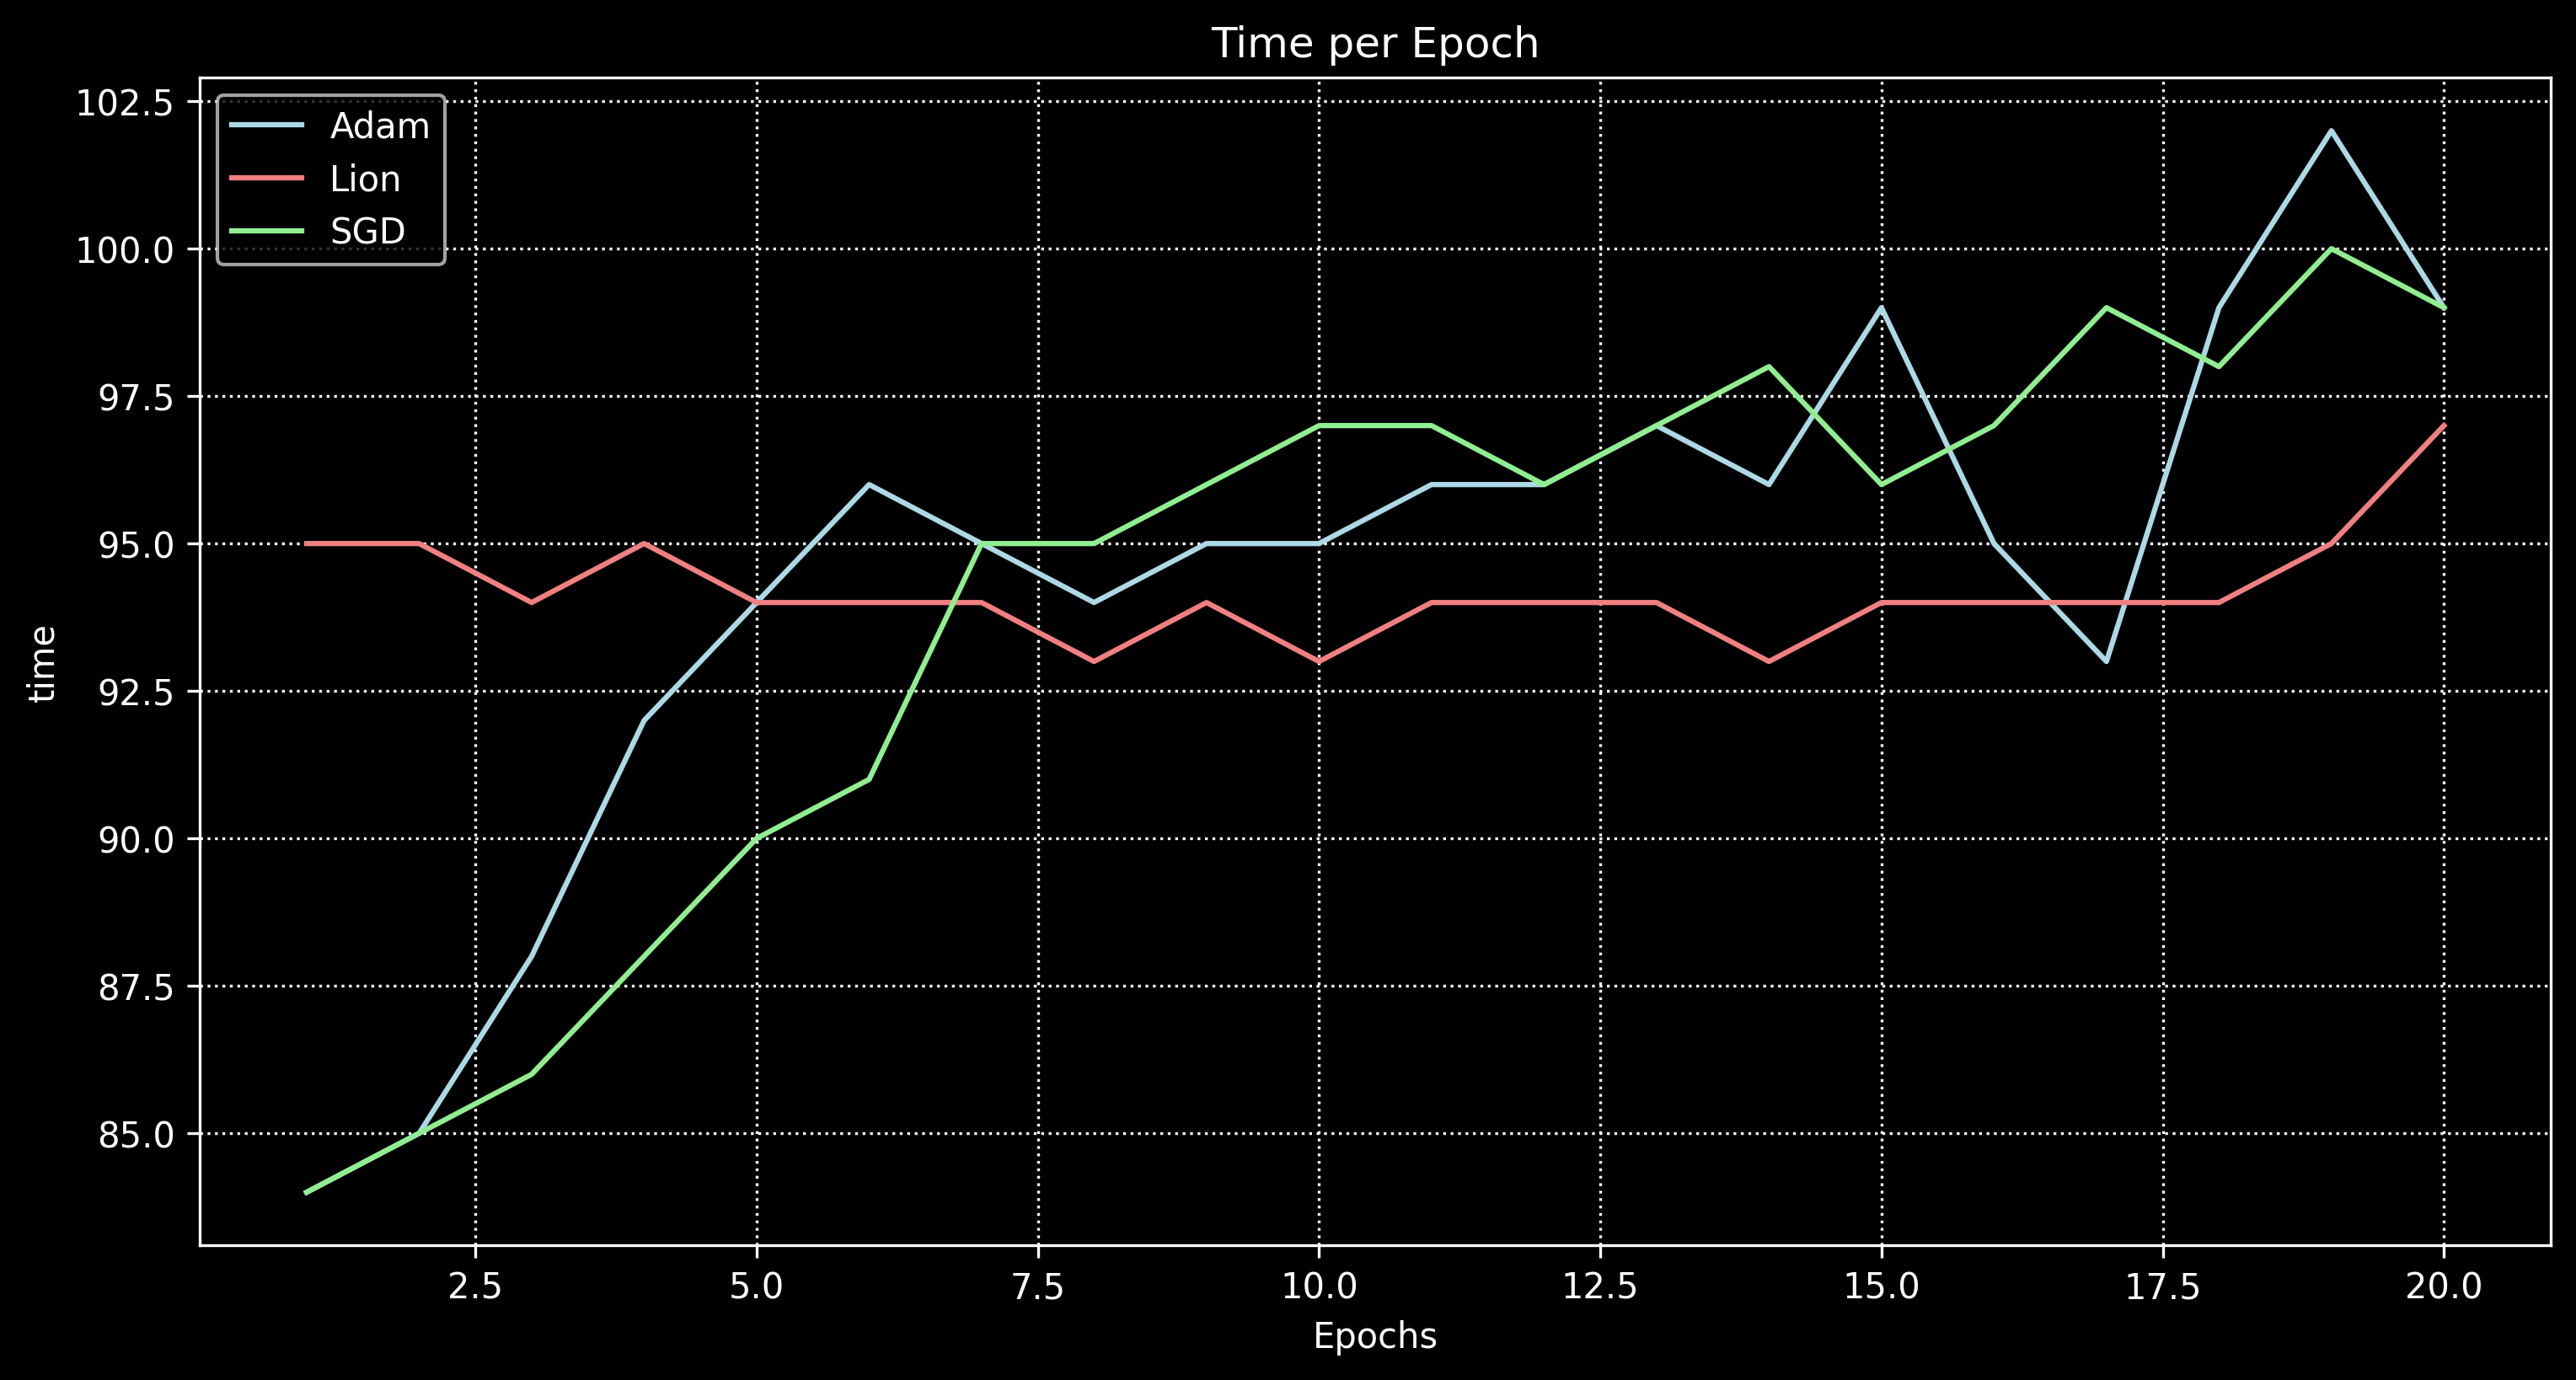

In [196]:
# Set dark theme and font
plt.style.use('dark_background')

# Define a function to plot the metrics with more aesthetically pleasing colors
def plot_metrics_pretty(df1, df2, df3, metric, title):
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(df1['epoch'], df1[metric], label='Adam', color='lightblue')
    plt.plot(df2['epoch'], df2[metric], label='Lion', color='lightcoral')
    plt.plot(df3['epoch'], df3[metric], label='SGD', color='lightgreen')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, linestyle='dotted')
    plt.show()

# Plot validation accuracy
plot_metrics_pretty(df1, df2, df3, 'val_acc', 'Validation Accuracy')

# Plot validation loss
plot_metrics_pretty(df1, df2, df3, 'val_loss', 'Validation Loss')

# Plot time
plot_metrics_pretty(df1, df2, df3, 'time', 'Time per Epoch')

In [198]:
# Calculate the mean of time, validation loss, and validation accuracy for each model
model_means = {
    'adam': [df1['time'].mean(), df1['val_loss'].mean(), df1['val_acc'].mean()],
    'lion': [df2['time'].mean(), df2['val_loss'].mean(), df2['val_acc'].mean()],
    'sgd': [df3['time'].mean(), df3['val_loss'].mean(), df3['val_acc'].mean()]
}

# Convert the dictionary to a DataFrame
model_means_df = pd.DataFrame(model_means, index=['Time', 'Validation Loss', 'Validation Accuracy'])

# Transpose the DataFrame to have the models as rows and metrics as columns
model_means_df = model_means_df.transpose()

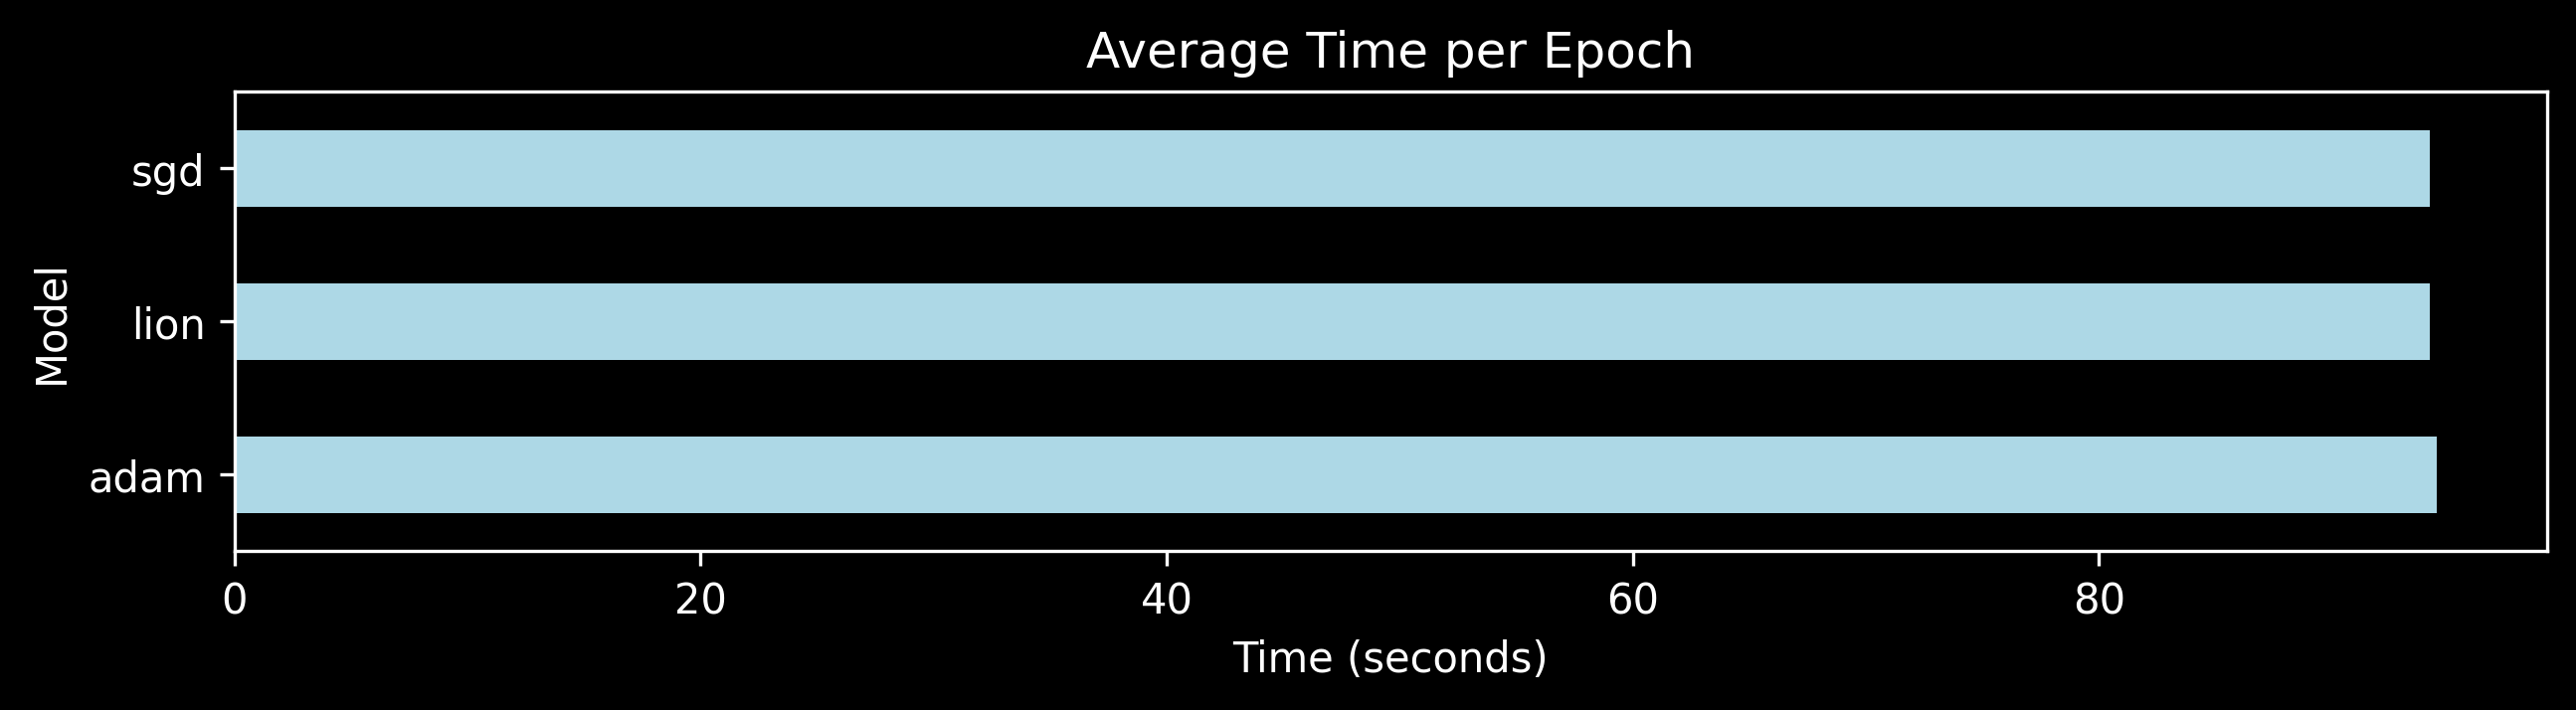

In [220]:
# Split the data into two DataFrames for easier plotting
time_df = model_means_df['Time']
val_df = model_means_df[['Validation Loss', 'Validation Accuracy']]

# Plot time
plt.figure(figsize=(10, 2), dpi=300)
time_df.plot(kind='barh', color='lightblue', width=0.5)
plt.title('Average Time per Epoch')
plt.xlabel('Time (seconds)')
plt.ylabel('Model')
plt.grid(False)
plt.show()

<Figure size 1500x900 with 0 Axes>

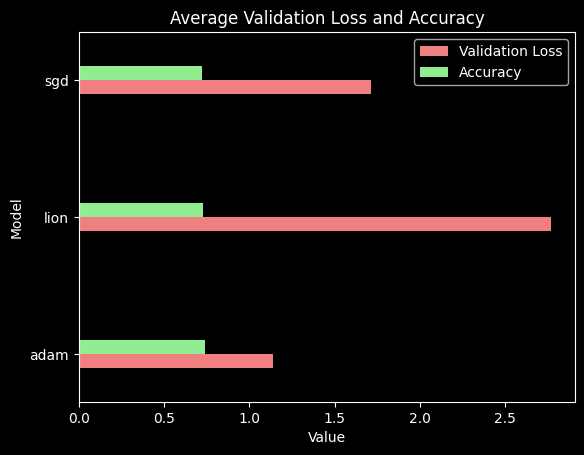

In [235]:
# Plot validation loss and accuracy
plt.figure(figsize=(10, 6), dpi = 150)

val_df.plot(kind='barh', color=['lightcoral', 'lightgreen'], width=0.2)

plt.title('Average Validation Loss and Accuracy')
plt.xlabel('Value')
plt.ylabel('Model')
plt.legend(loc='best', labels=['Validation Loss', 'Accuracy'])
plt.grid(False)

plt.show()